Thinkful Bootcamp Course

Author: Ian Heaton

Email: iheaton@gmail.com

Mentor: Nemanja Radojkovic

Date: 2017/06/21


In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import spacy
import re

from nltk.corpus import gutenberg
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

%matplotlib inline

sb.set_style('darkgrid')
my_dpi = 96

# LSA Drills





In [2]:
#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))


In [3]:
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

# splitting into training and test sets
X_train, X_test = train_test_split(emma_paras,test_size=0.4, random_state=0)

# Applying the vectorizer
X_train_tfidf=vectorizer.fit_transform(X_train)
print("Number of features: %d" % X_train_tfidf.get_shape()[1])

# Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

# number of paragraphs
n = X_train_tfidf_csr.shape[0]
# A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
# List of features
terms = vectorizer.get_feature_names()
# for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1379
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.70246133486836493, 'present': 0.71172190707814709}


In [4]:
#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 48.0468484007
Component 0:
" Oh !    0.999244
" Oh !    0.999244
" Oh !    0.999244
" Oh !    0.999244
" Oh !    0.999244
" Oh !    0.999244
" Oh !    0.999244
" Oh !    0.999244
" Oh !    0.999244
" Oh !    0.999244
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.672923
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.601172
" There were misunderstandings between them , Emma ; he said so expressly .                                                                                                 0.590741
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a ba

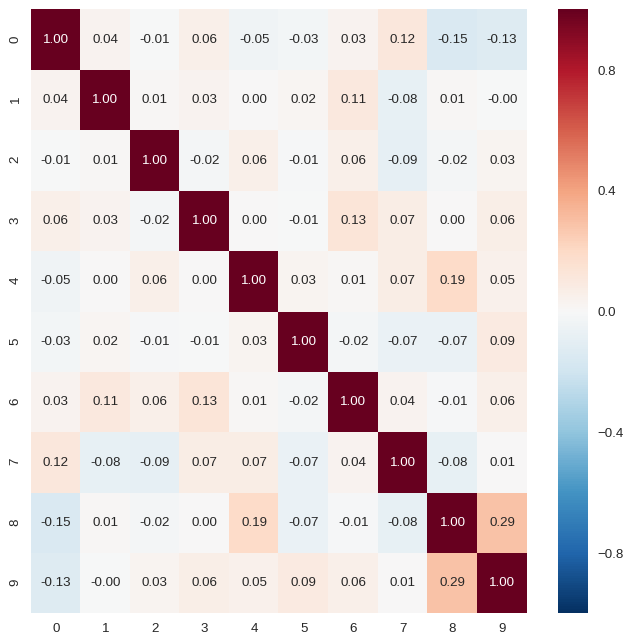

In [5]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
__ = sb.heatmap(sim_matrix,yticklabels=range(10), annot=True, fmt=".2f")

## Drill 0
Appling Latent Semantic Analysis model to the test set.

In [6]:
# Applying the vectorizer
X_test_tfidf=vectorizer.fit_transform(X_test)
print("Number of features in test : %d" % X_test_tfidf.get_shape()[1])

# Reshapes the vectorizer output into something people can read
X_test_tfidf_csr = X_test_tfidf.tocsr()

# number of paragraphs
n = X_test_tfidf_csr.shape[0]
print("The number of paragraphs in test data : %d" % n)
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
# List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_test_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_test_tfidf_csr[i, j]

# Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that 
# the word was present once in that sentence.
print('Original sentence:', X_test[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features in test : 1029
The number of paragraphs in test data : 949
Original sentence: " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
Tf_idf vector: {'pass': 0.28591298493659739, 'resolving': 0.31859056127148594, 'assure': 0.2723505653720717, 'watch': 0.6100562834139206, 'quite': 0.19766915990927683, 'mrs': 0.15619521683223178, 'friends': 0.26679782816623454, 'replied': 0.2116362495750182, 'unexceptionable': 0.31859056127148594, 'really': 0.23967298903718312, 'elton': 0.17895867324012965}


In [7]:
# Run SVD on the training data, then project the training data.
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa, index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 54.2432094963
Component 0:
" Oh !    0.999907
" Oh !    0.999907
" Oh !    0.999907
" Oh !    0.999907
" Oh !    0.999907
" Oh !    0.999907
" Oh !    0.999907
" Oh !    0.999907
" Oh !    0.999907
" Oh !    0.999907
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.618228
After tea , Mr . and Mrs . Weston , and Mr . Elton sat down with Mr . Woodhouse to cards .                                                                                                                                                                     

Key:
0 - Mr . Woodhouse had so completely made up his mind to the visit , that in spite of the increasing coldness , he seemed to have no idea of shrinking from it , and set forward at last most punctually with his eldest daughter in his own carriage , with less apparent consciousness of the weather than either of the others ; too full of the wonder of his own going , and the pleasure it was to afford at Randalls to see that it was cold , and too well wrapt up to feel it .

1 - " Oh !

2 - " Oh no , no !

3 - Such was Jane Fairfax ' s history .

4 - " That has been a good deal the case , my dear ; but not to the degree you mention .

5 - " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."

6 - " And here is Mrs . Weston and Mr . Frank Churchill too ! Quite delightful ; so many friends !"

7 - " You may well class the delight , the

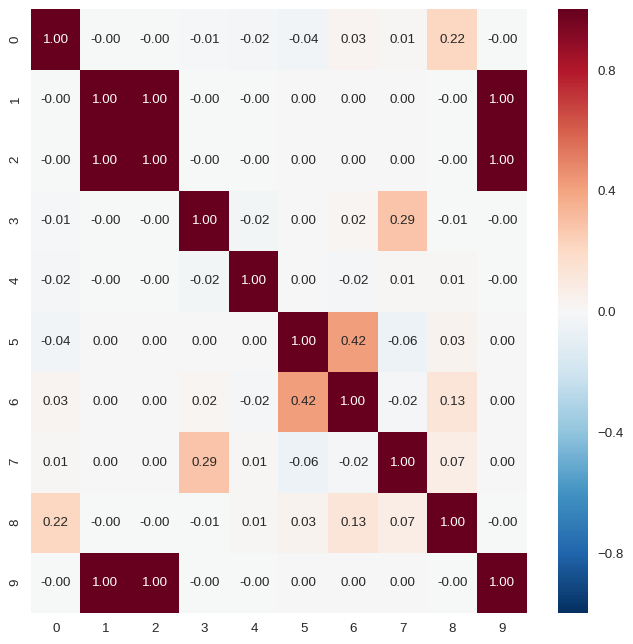

In [11]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_test_lsa) * np.asmatrix(X_test_lsa).T)
# Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity, index=X_test).iloc[0:10,0:10]
# Making a plot
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
__ = sb.heatmap(sim_matrix,yticklabels=range(10), annot=True, fmt=".2f")

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print('%s - %s\n' % (i,sim_matrix.index[i]))

Performing latent semantic analysis on the test set identified similar components to that seen in the training set.  Specifically, components 0, 2 and 3.   The similarity matrix on the test data reveals a number of paragraphs pairs with perfect similarity. 

## Drill 1 : Tweaking tf-idf

Use SpaCy to normalize the paragraph text, removing stop words and punctuation.  The process will find stems and remove digits from the text. 


In [12]:
nlp = spacy.load('en')
print('There are %d paragraphs\n' % len(emma_paras))

emma_doc = []

for para in emma_paras:
    emma_doc.append(nlp(para))

print('There are %d paragraphs\n' % len(emma_doc))

# normalize the paragraphs
normalized_emma = []

for para in emma_doc:
    l = [token.lemma_ for token in para if not token.is_punct and not token.is_stop and not token.is_digit]
    normalized_emma.append(' '.join(l))

print('There are %d normalized paragraphs\n' % len(normalized_emma))

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

# splitting into training and test sets
X_train, X_test = train_test_split(normalized_emma,test_size=0.4, random_state=0)

# Applying the vectorizer
X_train_tfidf=vectorizer.fit_transform(X_train)
print("Number of features: %d" % X_train_tfidf.get_shape()[1])

# Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

# number of paragraphs
n = X_train_tfidf_csr.shape[0]
print("The number of paragraphs in training data : %d" % n)

# A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

# List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that 
# the word was present once in that sentence.
print('Original normalized sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

There are 2371 paragraphs

There are 2371 paragraphs

There are 2371 normalized paragraphs

Number of features: 1200
The number of paragraphs in training data : 1422
Original normalized sentence: minute complete present trial
Tf_idf vector: {'complete': 0.65056014297138987, 'minute': 0.53085943889255371, 'present': 0.54310197616628841}


In [13]:
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa, index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 51.3323733753
Component 0:
oh    0.999085
oh    0.999085
oh    0.999085
oh    0.999085
oh    0.999085
oh    0.999085
oh    0.999085
oh    0.999085
oh    0.999085
oh    0.999085
Name: 0, dtype: float64
Component 1:
tall emma say mr knightley                                                                                                                                                                                                                                                                                                                                                                                                 0.631168
know opinion mrs weston say mr knightley great intimacy emma harriet smith think bad thing                                                                                                                                                                                                                                       

Key:
0 - court

1 - yes sir oblige kind solicitude

2 - business engross plain circumstance forget inquire book recommend

3 - restrain manner immediately prepare speak exquisite calmness gravity weather night scarcely begin scarcely pass sweep gate join carriage find subject cut   hand seize   attention demand mr elton actually make violent love avail precious opportunity declare sentiment know hop   fear   adore   ready die refuse flatter ardent attachment unequalled love unexampled passion fail have effect short resolve seriously accept soon possible

4 - emma smile answer visit use nervous complaint hope charm away sore throat severe cold

5 - minute complete present trial

6 - delighted hear speak stoutly subject reply emma smile mean deny time   distant   give reason understand care

7 - intend tell

8 - laugh answer good humouredly

9 - appear perfectly good understanding begin quickly check add impossible term   scene



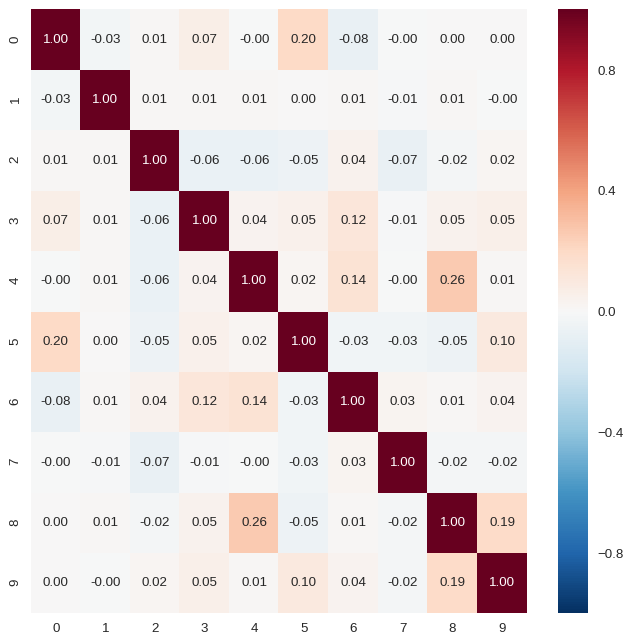

In [14]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
__ = sb.heatmap(sim_matrix,yticklabels=range(10), annot=True, fmt=".2f")

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print('%s - %s\n' % (i,sim_matrix.index[i]))

## Discussion

The first drill was running LSA on the test data resulted high similarity between sentences of the varies components.  As can be seen from the output of the components, 3 of them have the phrase ‘Oh !’  resulting in the similarity matrix having similarity scores of 1 for component 1, 2 and 9. 

The second drill consisted of tweaking TI-IDF construction with text normalization with SpaCy.  Paragraph text was normalized, removing stop words and punctuation.  In addition,  digits were removed from the text. This greatly altered the contents of the SVD components.  This in turn reduced the amount of similarity between component sentences.  From the heatmap ignoring the diagonal the highest similarity score is 0.26 between sentences 4 and 8 which both contain the word answer.